<a href="https://colab.research.google.com/github/boscodeeromeu/NN/blob/main/STUDENT_Lab_2_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 (Part 2): Regularizing MLPs


------------------------------------------------------
*Neural Networks. Bachelor in Data Science and Engineering*

*Pablo M. Olmos pamartin@ing.uc3m.es*

*Aurora Cobo Aguilera acobo@tsc.uc3m.es*

------------------------------------------------------
**Student: Bosco de Enrique (100406718)**

In this second part of the lab, you'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. You can see a sample below.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem you will notice that the model **easily overfits**, so addressing this issue is an important problem here. To do so, we will experiment with early stopping and dropout.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [3]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Lets take a look to the mini-batch size and plot a sample.

In [14]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

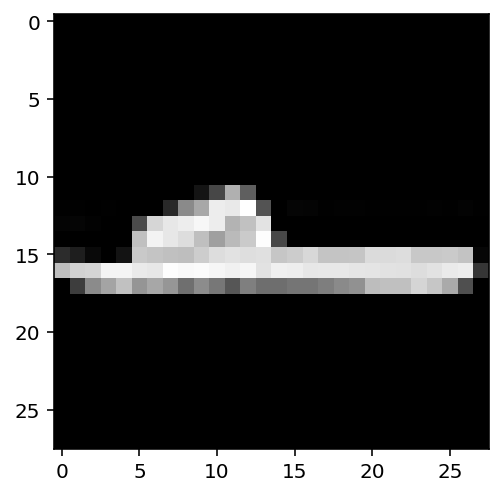

In [5]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Visualize overfiting

> **Exercise**: Train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. Use ReLU activation functions, and a log-Softmax output layer. To do so, complete the following steps: 
> - Create a class defining the NN model 
> - Extend the class to incorporate a training method. **Call it trainloop instead of train**. The reason will be clear later.
> - Train the model for 30 epochs and evaluate train/test performance

In [26]:
class MLP(nn.Module):

  def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels):
    super().__init__()
        
    self.output1 = nn.Linear(dimx,hidden1)
        
    self.output2 = nn.Linear(hidden1,hidden2)
        
    self.output3 = nn.Linear(hidden2,hidden3)

    self.output4 = nn.Linear(hidden3,nlabels)
    
    self.relu = nn.ReLU()
        
    self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
  def forward(self, x):
    # Pass the input tensor through each of our operations
    x = self.output1(x)
    x = self.relu(x)
    x = self.output2(x)
    x = self.relu(x)
    x = self.output3(x)
    x = self.relu(x)
    x = self.output4(x)
    x = self.logsoftmax(x)
    return x

  

In [27]:
class MLP_extended(MLP):
    
    def __init__(self,dimx,hidden1, hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1, hidden2, hidden3,nlabels)  
        
        self.lr = lr
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              

        self.loss_during_training = [] 
        
    def trainloop(self,trainloader):
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:             
        
                self.optim.zero_grad() 

                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0):
              
                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                
    def evaluate(self,dataloader):
      accuracy = 0

      with torch.no_grad():

        for images,labels in dataloader:

          logprobs = self.forward(images.view(images.shape[0], -1)) 
        
          top_p, top_class = logprobs.topk(1, dim=1)
          equals = (top_class == labels.view(images.shape[0], 1))
          accuracy += torch.mean(equals.type(torch.FloatTensor))
        
      return accuracy/len(dataloader)

In [29]:
my_MLP = MLP_extended(784, 256 ,128, 64, 10, 30, 0.001)
my_MLP.trainloop(trainloader)

Training loss after 0 epochs: 0.518487
Training loss after 1 epochs: 0.378278
Training loss after 2 epochs: 0.341137
Training loss after 3 epochs: 0.311672
Training loss after 4 epochs: 0.295447
Training loss after 5 epochs: 0.276934
Training loss after 6 epochs: 0.267264
Training loss after 7 epochs: 0.251297
Training loss after 8 epochs: 0.241710
Training loss after 9 epochs: 0.227551
Training loss after 10 epochs: 0.220153
Training loss after 11 epochs: 0.212539
Training loss after 12 epochs: 0.202012
Training loss after 13 epochs: 0.195353
Training loss after 14 epochs: 0.186859
Training loss after 15 epochs: 0.176593
Training loss after 16 epochs: 0.173741
Training loss after 17 epochs: 0.165196
Training loss after 18 epochs: 0.158695
Training loss after 19 epochs: 0.152859
Training loss after 20 epochs: 0.145904
Training loss after 21 epochs: 0.142727
Training loss after 22 epochs: 0.135504
Training loss after 23 epochs: 0.130856
Training loss after 24 epochs: 0.125931
Training l

In [30]:
train_acc = my_MLP.evaluate(trainloader)
test_acc = my_MLP.evaluate(testloader)

In [31]:
print('Train accuracy is {}, Test accuracy is {}'.format(train_acc, test_acc))

Train accuracy is 0.9649520516395569, Test accuracy is 0.8903264403343201


In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training. 

With the following code we split the train set into one training set (45k images) and a validation set (15k images). We do a naive splitting assuming that the data is randomized. **Keep in mind that in general you can do something smarter than this like K-Fold cross validation**, but here we keep it simple.



In [32]:
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

> **Exercise**: Modify your code class above so that, during training, everytime an epoch is finished you compute the loss function over the validation set. You must store these values into a list name as `valid_loss_during_training`. When performing this step, do not forget to turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs. Compute the final train/validation/test performance.

In [38]:
class MLP_extended(MLP):
    
    def __init__(self,dimx,hidden1, hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1, hidden2, hidden3,nlabels)  
        
        self.lr = lr
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              

        self.loss_during_training = [] 

        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader, validloader):
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:             
        
                self.optim.zero_grad() 

                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
            
            
            # we compute the validation loss after each epoch
            with torch.no_grad():
              
              running_loss_v = 0.

              for images, labels in validloader:

                out_v = self.forward(images.view(images.shape[0], -1))

                loss_v = self.criterion(out_v, labels)

                running_loss_v += loss_v.item()

              self.valid_loss_during_training.append(running_loss_v/len(validloader))

                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0):
              
                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                
    def evaluate(self,dataloader):
      accuracy = 0

      with torch.no_grad():

        for images,labels in dataloader:

          logprobs = self.forward(images.view(images.shape[0], -1)) 
        
          top_p, top_class = logprobs.topk(1, dim=1)
          equals = (top_class == labels.view(images.shape[0], 1))
          accuracy += torch.mean(equals.type(torch.FloatTensor))
        
      return accuracy/len(dataloader)

In [43]:
my_MLP = MLP_extended(784, 256 ,128, 64, 10, 30, 0.001)
my_MLP.trainloop(trainloader, validloader)

Training loss after 0 epochs: 0.548394
Training loss after 1 epochs: 0.386616
Training loss after 2 epochs: 0.348306
Training loss after 3 epochs: 0.320470
Training loss after 4 epochs: 0.304794
Training loss after 5 epochs: 0.286263
Training loss after 6 epochs: 0.269499
Training loss after 7 epochs: 0.258641
Training loss after 8 epochs: 0.247738
Training loss after 9 epochs: 0.233479
Training loss after 10 epochs: 0.224750
Training loss after 11 epochs: 0.213362
Training loss after 12 epochs: 0.207102
Training loss after 13 epochs: 0.199515
Training loss after 14 epochs: 0.190906
Training loss after 15 epochs: 0.188090
Training loss after 16 epochs: 0.174864
Training loss after 17 epochs: 0.169034
Training loss after 18 epochs: 0.161060
Training loss after 19 epochs: 0.153886
Training loss after 20 epochs: 0.147786
Training loss after 21 epochs: 0.141918
Training loss after 22 epochs: 0.140348
Training loss after 23 epochs: 0.129424
Training loss after 24 epochs: 0.128111
Training l

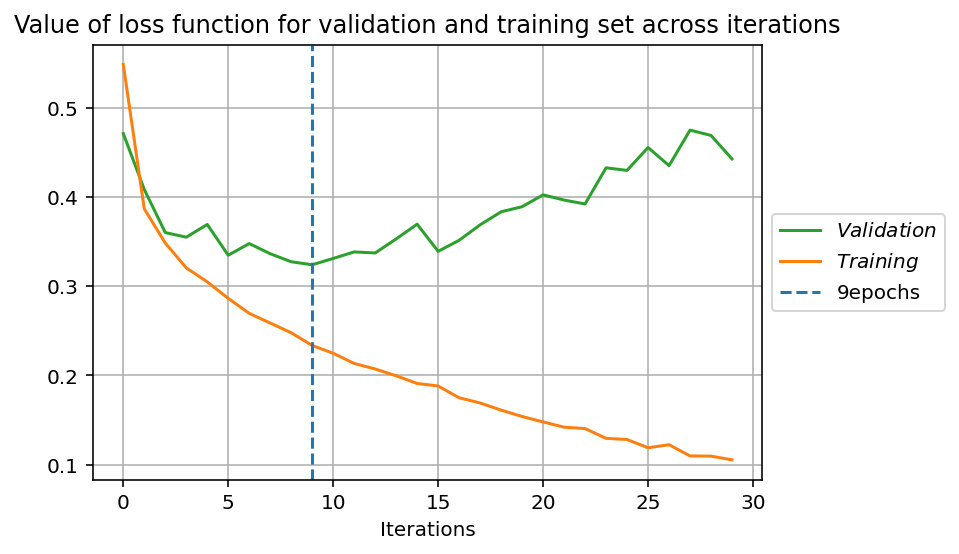

In [47]:
plt.plot(my_MLP.valid_loss_during_training, color = 'C2',label='$Validation$')
plt.plot(my_MLP.loss_during_training, color = 'C1',label='$Training$')
opt_epochs = my_MLP.valid_loss_during_training.index(min(my_MLP.valid_loss_during_training))
plt.axvline(x=opt_epochs, ls='--', label = str(opt_epochs) + 'epochs')

plt.title('Value of loss function for validation and training set across iterations')
plt.xlabel('Iterations')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [48]:
train_acc = my_MLP.evaluate(trainloader)
valid_acc = my_MLP.evaluate(validloader)
test_acc = my_MLP.evaluate(testloader)

In [50]:
print('Train accuracy is {}, Test accuracy is {}, Validation accuracy is{}'.format(train_acc, test_acc, valid_acc ))

Train accuracy is 0.9630237817764282, Test accuracy is 0.8812699317932129, Validation accuracy is0.8891843557357788


If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.**

> **Exercise:** According to your results, re-train the model again for the right number of epochs (just before the validation loss starts to grow). Compare the train, validation and test performance.

In [52]:
my_MLP = MLP_extended(784, 256 ,128, 64, 10, 9, 0.001)
my_MLP.trainloop(trainloader, validloader)

Training loss after 0 epochs: 0.550224
Training loss after 1 epochs: 0.385955
Training loss after 2 epochs: 0.347406
Training loss after 3 epochs: 0.321849
Training loss after 4 epochs: 0.301096
Training loss after 5 epochs: 0.281924
Training loss after 6 epochs: 0.267513
Training loss after 7 epochs: 0.259801
Training loss after 8 epochs: 0.242257


In [53]:
train_acc = my_MLP.evaluate(trainloader)
valid_acc = my_MLP.evaluate(validloader)
test_acc = my_MLP.evaluate(testloader)

In [55]:
print('Train accuracy is {}, Test accuracy is {}, Validation accuracy is {}'.format(train_acc, test_acc, valid_acc ))

Train accuracy is 0.9187899231910706, Test accuracy is 0.8788813948631287, Validation accuracy is 0.886303186416626


**ANSWER:**

After applying early-stopping we get a less overfitted model as we have reduced the training accuracy by 0.05 points, going then from a difference between validation/test and train of almost 0.1 to more or less 0.03.

Therefore we have improved our model, as it is able to better generalize unseen data; however, we can/should perform further regularizing steps as the difference between train and unknown data is still considerable.

## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

The following code corresponds to a 2 layer NN where we use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `self.train()` (**This is why we cannot call our training method `train` anymore**). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    self.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
self.train()
```

> **Exercise:** 
> - Create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied. 
> - Modify the extended class to set `model.eval()` when appropiate (do not forget to go back to `model.train()`)
> - For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`. Which value provides the best validation performance? 

In [62]:
class MLPdrop(nn.Module):
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels, drop_proportion=.2):
      super().__init__()
        
      self.output1 = nn.Linear(dimx,hidden1)
        
      self.output2 = nn.Linear(hidden1,hidden2)
        
      self.output3 = nn.Linear(hidden2,hidden3)

      self.output4 = nn.Linear(hidden3,nlabels)
    
      self.relu = nn.ReLU()
      
      self.logsoftmax = nn.LogSoftmax(dim=1)                                                             

      self.dropout = nn.Dropout(p=drop_proportion)

    def forward(self, x):
      # Pass the input tensor through each of our operations
      x = self.output1(x)
      x = self.relu(x)
      x = self.dropout(x)
    
      x = self.output2(x)
      x = self.relu(x)
      x = self.dropout(x)

      x = self.output3(x)
      x = self.relu(x)
      x = self.dropout(x)

      x = self.output4(x)
      x = self.logsoftmax(x)
      
      return x

In [61]:
class MLPdrop_extended(MLPdrop):
    
    def __init__(self,dimx,hidden1, hidden2,hidden3,nlabels,epochs,lr, drop_proportion):
        
        super().__init__(dimx,hidden1, hidden2, hidden3,nlabels, drop_proportion)  
        
        self.lr = lr
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()              

        self.loss_during_training = [] 

        self.valid_loss_during_training = []
        
    def trainloop(self,trainloader, validloader):
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:             
        
                self.optim.zero_grad() 

                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
            
            
            # we compute the validation loss after each epoch
            with torch.no_grad():
              
              self.eval()

              running_loss_v = 0.

              for images, labels in validloader:

                out_v = self.forward(images.view(images.shape[0], -1))

                loss_v = self.criterion(out_v, labels)

                running_loss_v += loss_v.item()

              self.valid_loss_during_training.append(running_loss_v/len(validloader))

            self.train()

            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0):
              
                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                
    def evaluate(self,dataloader):
      accuracy = 0

      with torch.no_grad():

        self.eval()

        for images,labels in dataloader:

          logprobs = self.forward(images.view(images.shape[0], -1)) 
        
          top_p, top_class = logprobs.topk(1, dim=1)
          equals = (top_class == labels.view(images.shape[0], 1))
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      
      self.train()

      return accuracy/len(dataloader)

In [63]:
my_MLP = MLPdrop_extended(784, 256 ,128, 64, 10, 30, 0.001, 0.2)
my_MLP.trainloop(trainloader, validloader)

Training loss after 0 epochs: 0.643728
Training loss after 1 epochs: 0.457502
Training loss after 2 epochs: 0.414236
Training loss after 3 epochs: 0.392063
Training loss after 4 epochs: 0.369018
Training loss after 5 epochs: 0.352380
Training loss after 6 epochs: 0.341005
Training loss after 7 epochs: 0.332920
Training loss after 8 epochs: 0.320147
Training loss after 9 epochs: 0.314420
Training loss after 10 epochs: 0.304081
Training loss after 11 epochs: 0.298717
Training loss after 12 epochs: 0.292010
Training loss after 13 epochs: 0.285783
Training loss after 14 epochs: 0.279657
Training loss after 15 epochs: 0.272089
Training loss after 16 epochs: 0.266470
Training loss after 17 epochs: 0.260883
Training loss after 18 epochs: 0.258933
Training loss after 19 epochs: 0.259092
Training loss after 20 epochs: 0.255387
Training loss after 21 epochs: 0.248230
Training loss after 22 epochs: 0.242556
Training loss after 23 epochs: 0.238539
Training loss after 24 epochs: 0.234338
Training l

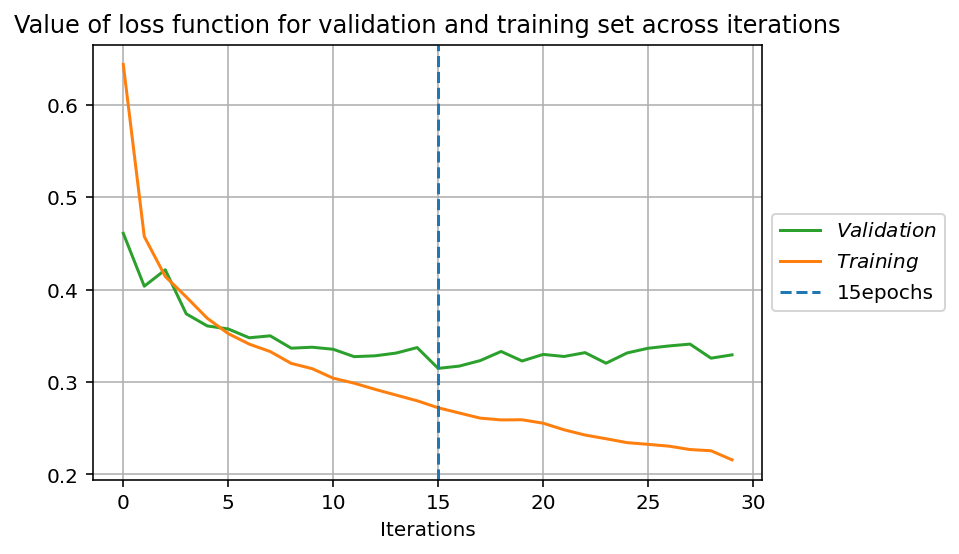

In [64]:
plt.plot(my_MLP.valid_loss_during_training, color = 'C2',label='$Validation$')
plt.plot(my_MLP.loss_during_training, color = 'C1',label='$Training$')
opt_epochs = my_MLP.valid_loss_during_training.index(min(my_MLP.valid_loss_during_training))
plt.axvline(x=opt_epochs, ls='--', label = str(opt_epochs) + 'epochs')

plt.title('Value of loss function for validation and training set across iterations')
plt.xlabel('Iterations')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**ANSWER:**

There are a couple of differences with the losses we obtained without dropout. The first one is that, while without dropout the model started to overfit after epoch 8, here the loss functions diverge (i.e the model overfits) after epoch 12-15. This implies that the model is able to learn more deeply the parameters without reproducing training data.

The second observation is that, compared to the loss evolution we observed without dropout regularization, where the difference in loss between train and validation was noteworthy (around 0.35), here the difference between loss functions is around 0.1. Consequently we could say that the model overfits after epoch 15, but not so heavily as without dropout.

The fact that after half the epochs the loss functions diverge is a clear indicator that, in order to get the best possible model, we should combine early-stopping and dropout. In this case we should stop the learning around epoch 12-15.

In [65]:
train_acc = my_MLP.evaluate(trainloader)
valid_acc = my_MLP.evaluate(validloader)
test_acc = my_MLP.evaluate(testloader)

In [66]:
print('Train accuracy is {}, Test accuracy is {}, Validation accuracy is {}'.format(train_acc, test_acc, valid_acc ))

Train accuracy is 0.9367009997367859, Test accuracy is 0.881170392036438, Validation accuracy is 0.8910239338874817


**ANSWER:**

My conclusions on the loss function evolution are in line with the performance; the difference between the accuracies for known and unknown data is significant (around 0.05). Clearly the model is still overfitting. However, it improves the results we got without dropout (where the difference was 0.1); but not those we got with early-stopping (0.03). 

I'm strongly convinced that tuning the dropout parameter and performing early stopping at epoch 15 we can obtain optimal results. Let's check it.

In [82]:
import pandas as pd
drop_results = {'DropoutProportion': [.1, .2,.3], 'TrainAccuracy':[0, 0, 0], 'ValidationAccuracy':[0, 0, 0], 'TestAccuracy':[0, 0, 0]}
drop_results_df = pd.DataFrame(drop_results)
p_values = [.1, .2,.3]

for p in p_values:

  my_MLP = MLPdrop_extended(784, 256 ,128, 64, 10, 15, 0.001, p)
  my_MLP.trainloop(trainloader, validloader)
  
  drop_results_df.loc[drop_results_df['DropoutProportion']==p, 'TrainAccuracy'] = my_MLP.evaluate(trainloader).tolist()
  drop_results_df.loc[drop_results_df['DropoutProportion']==p, 'TestAccuracy'] = my_MLP.evaluate(testloader).tolist()
  drop_results_df.loc[drop_results_df['DropoutProportion']==p, 'ValidationAccuracy'] = my_MLP.evaluate(validloader).tolist()
  

Training loss after 0 epochs: 0.594196
Training loss after 1 epochs: 0.423329
Training loss after 2 epochs: 0.383475
Training loss after 3 epochs: 0.354897
Training loss after 4 epochs: 0.337079
Training loss after 5 epochs: 0.318735
Training loss after 6 epochs: 0.308315
Training loss after 7 epochs: 0.296432
Training loss after 8 epochs: 0.286519
Training loss after 9 epochs: 0.276820
Training loss after 10 epochs: 0.269705
Training loss after 11 epochs: 0.257684
Training loss after 12 epochs: 0.253856
Training loss after 13 epochs: 0.245456
Training loss after 14 epochs: 0.237092
Training loss after 0 epochs: 0.632088
Training loss after 1 epochs: 0.451417
Training loss after 2 epochs: 0.408902
Training loss after 3 epochs: 0.380796
Training loss after 4 epochs: 0.364472
Training loss after 5 epochs: 0.350513
Training loss after 6 epochs: 0.338431
Training loss after 7 epochs: 0.330543
Training loss after 8 epochs: 0.320719
Training loss after 9 epochs: 0.314638
Training loss after 

In [83]:
drop_results_df

,DropoutProportion,TrainAccuracy,ValidationAccuracy,TestAccuracy
0,0.1,0.917969,0.882979,0.874900
1,0.2,0.916593,0.885018,0.877687
2,0.3,0.908913,0.886082,0.878483


**ANSWER:**

It seems that with a .3 dropout proportion and early stopping at 15 epochs we get the best solution: we slightly increase the validation and test accuracies, while reducing the train accuracy (difference of only 0.02). This model seems to be quite good as there are no signs of overfitting whatsoever.

With 0.1 and 0.2 we get similar performances for unknown data, but the models seem to be a bit overfitted as the difference with the train accuracy is around 0.03.

After checking these results I believe it would be interesting to stop the training a bit earlier (maybe at epoch 13-14). However, as the results with 0.3 are quite good I don't believe it's essential to retrain the models.